# 01. Train in the Notebook & Deploy Model to ACI

* Load workspace
* Train a simple regression model directly in the Notebook python kernel
* Record run history
* Find the best model in run history and download it.
* Deploy the model as an Azure Container Instance (ACI)

## Prerequisites
1. Make sure you go through the [00. Installation and Configuration](00.configuration.ipynb) Notebook first if you haven't. 

2. Install following pre-requisite libraries to your conda environment and restart notebook.
```shell
(myenv) $ conda install -y matplotlib tqdm scikit-learn
```

3. Check that ACI is registered for your Azure Subscription.  

In [1]:
!az provider show -n Microsoft.ContainerInstance -o table

Namespace                    RegistrationState
---------------------------  -------------------
Microsoft.ContainerInstance  Registered


If ACI is not registered, run following command to register it. Note that you have to be a subscription owner, or this command will fail.

In [2]:
!az provider register -n Microsoft.ContainerInstance

## Validate Azure ML SDK installation and get version number for debugging purposes

In [3]:
from azureml.core import Experiment, Run, Workspace
import azureml.core

# Check core SDK version number
print("SDK version:", azureml.core.VERSION)

SDK version: 0.1.13


## Initialize Workspace

Initialize a workspace object from persisted configuration.

In [4]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

Found the config file in: D:\a\r1\a\AzureMlCli\sample-01\aml_config\config.json
Workspace name: notebooks
Azure region: eastus2
Subscription id: 4faaaf21-663f-4391-96fd-47197c630979
Resource group: aml_nb_git_5e3bb8c7


## Set run history name
Choose a name for your run history container in the workspace. 

In [5]:
experiment_name = 'train-in-notebook'

## Start a training run in local Notebook

In [6]:
# load diabetes dataset, a well-known small dataset that comes with scikit-learn
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

X, y = load_diabetes(return_X_y = True)
columns = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
data = {
    "train":{"X": X_train, "y": y_train},        
    "test":{"X": X_test, "y": y_test}
}

### Train a simple Ridge model
Train a very simple Ridge regression model in scikit-learn, and save it as a pickle file.

In [7]:
reg = Ridge(alpha = 0.03)
reg.fit(data['train']['X'], data['train']['y'])
preds = reg.predict(data['test']['X'])
print('Mean Squared Error is', mean_squared_error(preds, data['test']['y']))
joblib.dump(value = reg, filename = 'model.pkl');

Mean Squared Error is 3424.900315896017


### Add run history tracking
Now, let's add Azure ML run history logging, and upload persisted model into run history as well.

In [8]:
experiment = Experiment(workspace_object = ws, name = experiment_name)
run = experiment.start_logging()
run.tag("Description","My first run!")
run.log('alpha', 0.03)
reg = Ridge(alpha = 0.03)
reg.fit(data['train']['X'], data['train']['y'])
preds = reg.predict(data['test']['X'])
run.log('mse', mean_squared_error(preds, data['test']['y']))
joblib.dump(value = reg, filename = 'model.pkl')
run.upload_file(name = 'outputs/model.pkl', path_or_stream = './model.pkl')

run.complete()

We can browse to the recorded run history. Please make sure you use Chrome to navigate the run history page. Also to use helpers library, make sure you save a copy of [`helpers.py`](helpers.py) in the same folder where your notebook is.

In [9]:
import helpers
print(helpers.get_run_history_url(run))

https://mlworkspace.azureml-test.net/home/%2Fsubscriptions%2F4faaaf21-663f-4391-96fd-47197c630979%2FresourceGroups%2Faml_nb_git_5e3bb8c7%2Fproviders%2FMicrosoft.MachineLearningServices%2Fworkspaces%2Fnotebooks/projects/train-in-notebook/run-history/run-details/25048c79-d159-4fa4-95a9-fd8dad8b779a


### Simple parameter sweep
Sweep over alpha values of a sklearn ridge model, and capture metrics and trained model in Azure ML run history.

In [10]:
import numpy as np
import os
from tqdm import tqdm

model_name = "model.pkl"

# start a training run
root_run = experiment.start_logging()

# list of numbers from 0 to 1.0 with a 0.05 interval
alphas = np.arange(0.0, 1.0, 0.05)

# try a bunch of alpha values in a Linear Regression (Ridge) model
for alpha in tqdm(alphas):
    # create a bunch of child runs
    with root_run.child_run("alpha-" + str(alpha)) as run:
        # Use Ridge algorithm to build a regression model
        reg = Ridge(alpha = alpha)
        reg.fit(data["train"]["X"], data["train"]["y"])
        preds = reg.predict(data["test"]["X"])
        mse = mean_squared_error(preds, data["test"]["y"])

        # log alpha, mean_squared_error and feature names in run history
        run.log("alpha", alpha)
        run.log("mse", mse)
        run.log_list("columns", columns)

        with open(model_name, "wb") as file:
            joblib.dump(value = reg, filename = file)
        
        # upload the serialized model into run history record
        run.upload_file(name = "outputs/" + model_name, path_or_stream = model_name)

        # now delete the serialized model from local folder since it is already uploaded to run history 
        os.remove(model_name)
        
# Declare run completed
root_run.complete()
root_run_id = root_run.id
print ("run id:", root_run.id)

100%|██████████| 20/20 [00:58<00:00,  2.95s/it]


run id: 199b693b-2824-4d33-a072-a66ba6775a20


Now you can reconstruct this run object from captured run id in a different Notebook session.

In [11]:
rr = Run(experiment, run_id = root_run_id)

## Select best model from run history
Load all run metrics from run history into a dictionary object.

In [12]:
child_runs = {}
child_run_metrics = {}

for r in tqdm(rr.get_children()):
    child_runs[r.id] = r
    child_run_metrics[r.id] = r.get_metrics()

20it [00:07,  2.54it/s]


Now find the run with the lowest Mean Squared Error value

In [13]:
best_run_id = min(child_run_metrics, key = lambda k: child_run_metrics[k]['mse'])
best_run = child_runs[best_run_id]
print('Best run is:', best_run_id)
print('Metrics:', child_run_metrics[best_run_id])

Best run is: 786fe7fd-9096-4f62-a52d-e26c8cbac94c
Metrics: {'alpha': 0.4, 'mse': 3295.741064355809, 'columns': ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']}


You can add tags to your runs to make them easier to catalog

In [14]:
best_run.tag("Description","The best one")
best_run.get_tags()

{'Description': 'The best one'}

### Plot MSE over alpha

Let's observe the best model visually by plotting the MSE values over alpha values:

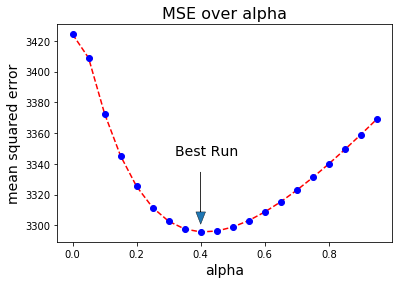

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

best_alpha = child_run_metrics[best_run_id]['alpha']
min_mse = child_run_metrics[best_run_id]['mse']

alpha_mse = np.array([(child_run_metrics[k]['alpha'], child_run_metrics[k]['mse']) for k in child_run_metrics.keys()])
sorted_alpha_mse = alpha_mse[alpha_mse[:,0].argsort()]

plt.plot(sorted_alpha_mse[:,0], sorted_alpha_mse[:,1], 'r--')
plt.plot(sorted_alpha_mse[:,0], sorted_alpha_mse[:,1], 'bo')

plt.xlabel('alpha', fontsize = 14)
plt.ylabel('mean squared error', fontsize = 14)
plt.title('MSE over alpha', fontsize = 16)

# plot arrow
plt.arrow(x = best_alpha, y = min_mse + 39, dx = 0, dy = -26, ls = '-', lw = 0.4,
          width = 0, head_width = .03, head_length = 8)

# plot "best run" text
plt.text(x = best_alpha - 0.08, y = min_mse + 50, s = 'Best Run', fontsize = 14)
plt.show()

## Register the best model

Find the model file saved in the run history record of best run.

In [16]:
for f in best_run.get_file_names():
    print(f)

outputs/model.pkl


Now we can register this model in the model registry of the workspace

In [17]:
model = best_run.register_model(model_name = 'best_model', model_path = 'outputs/model.pkl')

Verify that the model has been registered properly. If you have done this several times you'd see the version number auto-increases each time.

In [18]:
for m in ws.models(name = 'best_model'):
    print(m.name, m.version)

best_model 1


You can also download the registered model. Afterwards, you should see a `model.pkl` file in the current directory. You can then use it for local testing if you'd like.

In [19]:
model.download(target_dir = '.')

'.'

## Create scoring script

The scoring script consists of two functions: `init` that is used to load the model to memory when starting the container, and `run` that makes the prediction when web service is called.

The `%%writefile` cell magic is used to write the scoring function to a local file. Pay special attention to how the model is loaded in the `init()` function. When Docker image is built for this model, the actual model file is downloaded and placed on disk, and `get_model_path` function returns the local path where the model is placed.

In [20]:
%%writefile score.py
import pickle
import json
import numpy as np
from sklearn.externals import joblib
from sklearn.linear_model import Ridge
from azureml.core.model import Model

def init():
    global model
    # note here "best_model" is the name of the model registered under the workspace
    # this call should return the path to the model.pkl file on the local disk.
    model_path = Model.get_model_path(model_name = 'best_model')
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)

# note you can pass in multiple rows for scoring
def run(raw_data):
    try:
        data = json.loads(raw_data)['data']
        data = np.array(data)
        result = model.predict(data)
        return json.dumps({"result": result.tolist()})
    except Exception as e:
        result = str(e)
        return json.dumps({"error": result})

Writing score.py


## Create conda dependency file

This `myenv.yml` file is used to specify which library dependencies to install on the web service. Note that the CondaDependencies API automatically adds necessary Azure ML dependencies.

In [21]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies()
myenv.add_conda_package("numpy")
myenv.add_conda_package("scipy")

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

## Deploy web service into an Azure Container Instance
The deployment process takes the registered model and your scoring scrip, and builds a Docker image. It then deploys the Docker image into Azure Container Instance as a running container with an HTTP endpoint readying for scoring calls. Read more about [Azure Container Instance](https://azure.microsoft.com/en-us/services/container-instances/).

Note ACI is great for quick and cost-effective dev/test deployment scenarios. For production workloads, please use [Azure Kubernentes Service (AKS)](https://azure.microsoft.com/en-us/services/kubernetes-service/) instead. Please follow in struction in [this notebook](11.production-deploy-to-aks.ipynb) to see how that can be done from Azure ML.
 
** Note: ** The web service creation can take 6-7 minutes. Please be patient. We are working on making it much faster.

In [22]:
from azureml.core.webservice import AciWebservice, Webservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {'sample name': 'AML 101'}, 
                                               description = 'This is a great example.')

Note the below `WebService.deploy_from_model()` function takes a model object registered under the workspace. It then bakes the model file in the Docker image so it can be looked-up using the `Model.get_model_path()` function in `score.py`. 

If you have a local model file instead of a registered model object, you can also use the `WebService.deploy()` function which would register the model and then deploy.

In [23]:
from azureml.core.image import ContainerImage
image_config = ContainerImage.image_configuration(execution_script = "score.py", 
                                    runtime = "python", 
                                    conda_file = "myenv.yml")

In [24]:
%%time
# this will take 5-10 minutes to finish
# you can also use "az container list" command to find the ACI being deployed
service = Webservice.deploy_from_model(name = 'my-aci-svc-1',
                                       deployment_config = aciconfig,
                                       models = [model],
                                       image_config = image_config,
                                       workspace = ws)
service.wait_for_deployment(show_output = True)

Creating image
Image creation operation finished for image my-aci-svc-1:1, operation "Succeeded"
Creating service
Running....................................................................
SucceededACI service creation operation finished, operation "Succeeded"
Wall time: 10min 14s



## Test web service

In [25]:
print('web service is hosted in ACI:', service.scoring_uri)

web service is hosted in ACI: http://40.76.13.109:5001/score


Use the `run` API to call the web service with one row of data to get a prediction.

In [26]:
import json
# score the first row from the test set.
test_samples = json.dumps({"data": X_test[0:1, :].tolist()})
service.run(input_data = test_samples)

'{"result": [217.67978776218712]}'

Feed the entire test set and calculate the errors (residual values).

In [27]:
# score the entire test set.
test_samples = json.dumps({'data': X_test.tolist()})

result = json.loads(service.run(input_data = test_samples))['result']
residual = result - y_test

You can also send raw HTTP request to test the web service.

In [28]:
import requests
import json

# 2 rows of input data, each with 10 made-up numerical features
input_data = "{\"data\": [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]]}"

headers = {'Content-Type':'application/json'}

# for AKS deployment you'd need to the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post(service.scoring_uri, input_data, headers = headers)
print(resp.text)

"{\"result\": [5215.198131579873, 3726.995485938577]}"


## Residual graph
Plot a residual value graph to chart the errors on the entire test set. Observe the nice bell curve.

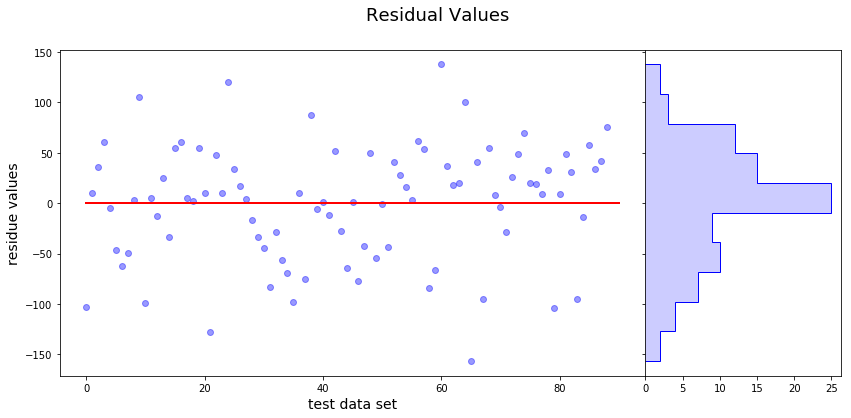

In [29]:
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[3, 1], 'wspace':0, 'hspace': 0})
f.suptitle('Residual Values', fontsize = 18)

f.set_figheight(6)
f.set_figwidth(14)

a0.plot(residual, 'bo', alpha = 0.4);
a0.plot([0,90], [0,0], 'r', lw = 2)
a0.set_ylabel('residue values', fontsize = 14)
a0.set_xlabel('test data set', fontsize = 14)

a1.hist(residual, orientation='horizontal', color='blue', bins = 10, histtype = 'step');
a1.hist(residual, orientation='horizontal', color='blue', alpha = 0.2, bins = 10);
a1.set_yticklabels([])

plt.show()

## Delete ACI to clean up

Deleting ACI is super fast!

In [30]:
%%time
service.delete()

Wall time: 1.94 s
